<a href="https://colab.research.google.com/github/v-zeng/data_mining_grad_projects/blob/main/CISC873_DM_F21_A2_zeng_vinson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Speed Dating Match Prediction**

Student: Vinson Zeng

Student #: 05550960

✔️Data Science Meme

<img src="https://drive.google.com/uc?id=1LtrAzDNb3yiXHF0kejLjuHx4u4gdaGAJ">

✔️Understand the Template

**What is the experimental protocol used and how was it carried out?**

Predict the probability (0-1, float) that a given dating data sample will lead to a succesful match. Build a pipeline with a random forest estimator and perform hyperparameter optimization using grid search. Measure performance of model with AUROC metric. Create submission using trained model and predict successful match probability for test data.

Build a second model using C-Support Vector Classification (SVC). as the estimator and optimize hyperparameters using Bayesian optimization. Score with default estimator method (SVC accuracy metric).

**How did we tune hyper-parameters in the template?**

Random forest classifier tuned with grid search. Exhaustive search over specified parameters in param_grid. The hyperparameters include the following:

*   'preprocessor__num__imputer__strategy': ['mean']
*   'my_classifier__n_estimators': [20, 30, 40]
*   'my_classifier__max_depth':[10, 20, 30]

GridSearchCV parameters:

*  cv=3
*  verbose=1
*  n_jobs=2
*  scoring='roc_auc'

SVC model is tuned with Bayesian optimization using BayesSearchCV. Search spaces include the following:

*  'my_svc__C': Real(1e-6, 1e+6, prior='log-uniform')
*  'my_svc__gamma': Real(1e-6, 1e+1, prior='log-uniform')
*  'my_svc__degree': Integer(1,8)
*  'my_svc__kernel': Categorical(['linear', 'poly', 'rbf'])

**What is the search space and what is the criteria to determine good/bad hyper-parameters?**

Search space is the set of all possible solutions for the hyperparameters, or the dimensions to search for parameters of the provided estimator.

For grid search, the evaluation of the combinations of hyper-parameters is given by the scoring as we defined it for the GridSearchCV parameter:

*   scoring='roc_auc'

AUC score closer to 1 indicates a better measure of separability (better model).




✔️ Problem Formulation:

**Define the problem. What is the input? What is the output?**

The problem is to predict the outcome of a specific speed dating session based on the profile of two people. It is a binary classification task in which the profiles of people are the inputs and the output is the probability of a successful match.

**What data mining function is required?**

Classification is the data mining function required.

**What could be the challenges?**

Data preprocessing, such as finding the optimal method to deal with the missing data, could be a challenge. Handling the imbalanced data could also be a challenge, as there are more unmatched cases than matched.

**What is the impact? What is an ideal solution?**

Data preprocessing is important since it may affect the accuracy and scoring of the model. For example, if missing values are are simply removed then information will be lost.

For imbalanced data, there will likely be more misclassification of the minority class (match). The majority class (unmatched) since has more data for the model to train on.

An ideal solution would have an AUC score of 1, as it would mean the ability of the classifier to distinguish between classes is perfect.

  ✔️ **Answer the questions below (briefly):**

🌈 Why a simple linear regression model (without any activation function) is not good for classification task, compared to Perceptron/Logistic regression?

A linear model tries to use a straight line to describe the relationship between the input and target variables, and predicts a continuous value. The linear model is sensitive to imbalanced data and outlier observations. This is problematic since classification data is typically imbalanced and varies non-linearly with independent variables. Linear regression prioritizes minimizing the loss function at the cost of misclassifying labels correctly.  

Logistic regression and perceptron models use non-linear activation functions - sigmoid and binary step, respectively. The input is transformed and are thresholded to 1 and 0 for perceptron and mapped between 0 and 1 for logistic regression. Such models should be used when target variables are discrete, such as in classification. These activation functions reduce the sensitivity of the models to outliers and transform inputs to predict discrete outcomes.

🌈What's a decision tree and how it is different to a logistic regression model?

A decision tree is a supervised machine learning method which can solve regression and classification problems. Nodes evaluate features that splits the data. The root node is the starting point which has all the training examples. Leaf nodes represent a class label. Decision trees are built recursively by evaluating metrics, such as entropy for categorical trees. Decision trees generate decision boundaries in a different manner than logistic regression. Logistic regression fits a single line (linear) while decision trees can draw multiple or non-linear boundaries to split the data points.

🌈We discussed three variants of decision tree (single-tree) in our lecture, what are their differences?

Iterative Dichotomiser 3 (ID3): Uses Info Gain to decide classifying attribute, handles categorical data, does not handle missing values, is sensitive to outliers/noise, no default pruning.

C4.5: Uses Gain Ratio, handles categorical and numeric data, handles missing values, is less sensitive than ID3 for outliers/noise, and uses pruning as its default setting.

Classification and Regression Tree (CART): uses Gini Index, handles categorical and numeric data, handles missing values, is robust to outliers/noise, and uses pruning as its default setting.

🌈What is the difference between the random forest model, and a bagging ensemble of CART models?

Random forest uses subsets of features selected at random and takes the best feature from the subset to split each node in a tree. Bagging considers all the features for splitting a node.

🌈How is gradient boosting different to boosting (adaboost)?

Gradient boosting calculates the residuals for each data point then combines them with a loss function to calculate overall loss. The loss function is differentiable, which is why gradient boosting uses gradient descent to minimize the overall loss. Adaboost assigns more weight to misclassified samples and less weight on those correctly classified. Weights affect the probability that the sample will be used to train the next weak learner.

**Template Code**

In [ ]:
# load modules and functions

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint

In [ ]:
# read in data

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data.shape # return shape of the array, which is 5909 rows and 192 columns

(5909, 192)

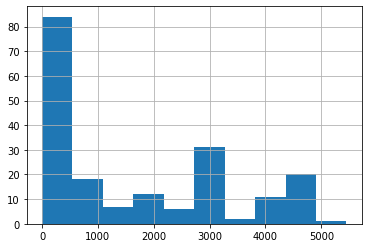

In [ ]:
data.isnull().sum().hist() # count of null values for columns as histogram


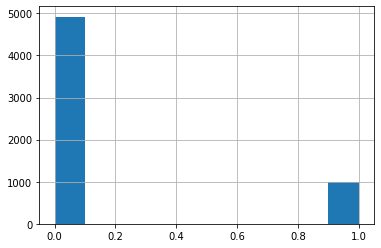

In [ ]:
 data['match'].hist() # count of 'match' column as histogram; binary, 1 is positive match

In [ ]:
# down-grade scikit-learn (latest not greatest :)
!pip install -Ivq scikit-learn==0.23.2

# if you haven't installed xgboost on your system, uncomment the line below
!pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

In [ ]:
x = data.drop('match', axis=1) # subset data as 'x' without 'match' feature
features_numeric = list(x.select_dtypes(include=['float64'])) # subset all features with data type 'float64'
features_categorical = list(x.select_dtypes(include=['object'])) # subset all features with data type 'object'
y = data['match'] # the dependent feature or response variable 'match'

In [ ]:
print(features_categorical) # print categorical features

['field', 'undergra', 'mn_sat', 'tuition', 'from', 'zipcode', 'income', 'career']


In [ ]:
# load modules and functions

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data.shape # return shape of the array, which is 5909 rows and 192 columns

x = data.drop('match', axis=1) # subset data as 'x' without 'match' feature
features_numeric = list(x.select_dtypes(include=['float64'])) # subset all features with data type 'float64'
features_categorical = list(x.select_dtypes(include=['object'])) # subset all features with data type 'object'
y = data['match'] # the dependent feature or response variable 'match'

# load modules and functions

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier

np.random.seed(0) # seed the number generator
# define steps with name and estimator object for numeric feaeture transformation pipeline
transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')), # replace missing values using median along each column
        ('scaler', StandardScaler())] # standardize features by removing mean and scaling to unit variance
)
# define pipeline steps for categorical feature transformation
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # replace missing values with 'missing'
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # columns will be all zeros if unknown categorical feature present during transform
    ]
)
# specify transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric), # specify numeric transformer application to numeric features subset
        ('cat', transformer_categorical, features_categorical) # specify categorical transformer application to categorical subset
    ]
)
# specify full pipeline steps for preprocessing and estimator/classifier
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_classifier',
           # XGBClassifier(objective='binary:logistic', seed=1), (another example)
           RandomForestClassifier(),
        )
    ]
)



# `__` denotes attribute
# (e.g. my_classifier__n_estimators means the `n_estimators` param for `my_classifier`
#  which is our xgb)
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'], # try 'mean' for numeric imputer strategy
    # 'my_classifier__n_estimators': [20, 30],  # this is for xgboost
    # 'my_classifier__max_depth':[10, 20]       # this is for xgboost
    'my_classifier__n_estimators': [20, 30, 40],    # this is for random forest
    'my_classifier__max_depth':[10, 20, 30]         # this is for random forest
}
# instantiate GridSearchCV object with pipeline
# cv=3: 3-fold cross validation for each combination of parameters
# verbose=1: computation time for each fold and parameter candidate is displayed
# n_jobs=2: run two jobs in parallel
# use 'roc_auc' evaluation
grid_search = GridSearchCV(
    full_pipline, param_grid, cv=3, verbose=1, n_jobs=2,
    scoring='roc_auc')

grid_search.fit(x, y) # fit grid search to training data

print('best score {}'.format(grid_search.best_score_)) # print best score
print('best score {}'.format(grid_search.best_params_)) # print parameters associated with best score

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  27 out of  27 | elapsed:   19.6s finished


best score 0.8341764456881043
best score {'my_classifier__max_depth': 10, 'my_classifier__n_estimators': 40, 'preprocessor__num__imputer__strategy': 'mean'}


In [ ]:
# display cv metrics as dataframe
print('all the cv scores')
pd.DataFrame(grid_search.cv_results_)

all the cv scores


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_my_classifier__max_depth,param_my_classifier__n_estimators,param_preprocessor__num__imputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.518147,0.024538,0.096559,0.004064,10,20,mean,"{'my_classifier__max_depth': 10, 'my_classifie...",0.843905,0.818285,0.799590,0.820594,0.018165,4
1,0.699235,0.027238,0.105055,0.004719,10,30,mean,"{'my_classifier__max_depth': 10, 'my_classifie...",0.826850,0.839697,0.824648,0.830398,0.006636,2
2,0.814523,0.001191,0.114847,0.002437,10,40,mean,"{'my_classifier__max_depth': 10, 'my_classifie...",0.843625,0.835194,0.823710,0.834176,0.008162,1
3,0.926312,0.021612,0.102522,0.003867,20,20,mean,"{'my_classifier__max_depth': 20, 'my_classifie...",0.808621,0.818111,0.808310,0.811680,0.004549,7
4,1.296493,0.015746,0.108479,0.001099,20,30,mean,"{'my_classifier__max_depth': 20, 'my_classifie...",0.830515,0.818577,0.807325,0.818806,0.009469,5
5,1.647878,0.029070,0.123605,0.000382,20,40,mean,"{'my_classifier__max_depth': 20, 'my_classifie...",0.833947,0.819010,0.819761,0.824239,0.006872,3
6,1.071362,0.013112,0.098858,0.001230,30,20,mean,"{'my_classifier__max_depth': 30, 'my_classifie...",0.807970,0.806083,0.790909,0.801654,0.007637,9
7,1.514848,0.003019,0.112680,0.002382,30,30,mean,"{'my_classifier__max_depth': 30, 'my_classifie...",0.820981,0.809568,0.799590,0.810046,0.008739,8
8,1.848197,0.115964,0.108797,0.021048,30,40,mean,"{'my_classifier__max_depth': 30, 'my_classifie...",0.826433,0.815881,0.802896,0.815070,0.009626,6


In [ ]:
# create submission
submission = pd.DataFrame() # create data frame
submission['id'] = data_test['id'] # set 'id' column elements with those from 'id' in data_test
submission['match'] = grid_search.predict_proba(data_test)[:,1] # probability of data belonging to class 1
submission.to_csv('sample_submission_walkthrough.csv', index=False) # save data to csv file without creating index
submission # preview data

,id,match
0,934,0.087602
1,6539,0.293644
2,6757,0.172368
3,2275,0.117874
4,1052,0.090979
...,...,...
2464,7982,0.165208
2465,7299,0.290775
2466,1818,0.086282
2467,937,0.106396


In [ ]:
# import classes

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC

# define SVC pipeline steps
SVC_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_svc', SVC(class_weight='balanced'))
    ]
)
# SVC has a class_weight attribute for unbalanced data

# define bayesian optimization estimator and search spaces
# search spaces contained in dictionary, where keys are parameter names and values are skopt.space.Dimension instances
bayes_search = BayesSearchCV(
    SVC_pipline,
    {
        'my_svc__C': Real(1e-6, 1e+6, prior='log-uniform'), # sample search space using 'log-uniform' distribution between ranges (optimizer will search between -6 and 6 here)
        'my_svc__gamma': Real(1e-6, 1e+1, prior='log-uniform'), # sample search space using 'log-uniform' distribution between ranges
        'my_svc__degree': Integer(1,8), # search space lower and upper boundary
        'my_svc__kernel': Categorical(['linear', 'poly', 'rbf']), # category dimensions
    },
    n_iter=4, # number of parameter settings that are sampled
    random_state=0, # use random numbers generated for random_state=0
    verbose=1, # set verbosity to 1 for level of details of CV
    cv=3, # 3-fold cross validation for each combination of parameters,
    scoring='roc_auc'
)

bayes_search.fit(x, y) # execute bayesian optimization

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.4s finished


BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('scaler',
                                                                                           StandardScaler())]),
                                                                          ['positin1',
                                                                           'pid',
                                                                           'int_corr',
                                                                           'age_o',
                                                             

In [ ]:
print('best score {}'.format(bayes_search.best_score_)) # print best score from bayesian optimization
print('best score {}'.format(bayes_search.best_params_)) # print parameters associated with best score

best score 0.8300336031166912
best score OrderedDict([('my_svc__C', 2.2095350994035026), ('my_svc__degree', 1), ('my_svc__gamma', 0.0002488766453161173), ('my_svc__kernel', 'linear')])


In [ ]:
print('all the cv scores')
pd.DataFrame(bayes_search.cv_results_) # print all cv scores

all the cv scores


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_my_svc__C,param_my_svc__degree,param_my_svc__gamma,param_my_svc__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,5.572630,0.838254,1.615847,0.049530,2.35272,6,0.0228543,poly,"{'my_svc__C': 2.352718564818733, 'my_svc__degr...",0.713784,0.719211,0.728781,0.720592,0.006200,2
1,6.239062,0.752136,1.676305,0.054127,0.00126026,8,2.28596,poly,"{'my_svc__C': 0.0012602593949011189, 'my_svc__...",0.699799,0.705394,0.713865,0.706353,0.005782,3
2,6.739534,0.250662,0.848755,0.015474,2.20954,1,0.000248877,linear,"{'my_svc__C': 2.2095350994035026, 'my_svc__deg...",0.840614,0.828442,0.821045,0.830034,0.008068,1
3,5.585071,0.011954,2.546070,0.050146,5.8754e-05,6,0.00194809,poly,"{'my_svc__C': 5.87540411933884e-05, 'my_svc__d...",0.646096,0.639311,0.663252,0.649553,0.010075,4


### **Trial0**

The random forest classifier had a grid search score of
0.8373225704615254. The best params are the following:


*   'my_classifier__max_depth': 10
*   'my_classifier__n_estimators': 40
*   'preprocessor__num__imputer__strategy': 'mean'

I will add 'most_frequent' and 'median' to the 'preprocessor__num__imputer__strategy' to see if those strategies can improve the performance.


In [ ]:
#0 imputer ='most_frequent' for num and cat transformers # univariate imputation... why?
#1 change param_grid values
#2 multi # multivariate imputation... why?

In [ ]:
### Trial0

# load modules and functions

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint

# read in data

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# data.shape # return shape of the array, which is 5909 rows and 192 columns

# data.isnull().sum().hist() # count of null values for columns as histogram
# data['match'].hist() # count of 'match' column as histogram; binary, 1 is positive match

#======================================================
# down-grade scikit-learn (latest not greatest :)
!pip install -Ivq scikit-learn==0.23.2

# if you haven't installed xgboost on your system, uncomment the line below
!pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

#======================================================
x = data.drop('match', axis=1) # subset data as 'x' without 'match' feature
features_numeric = list(x.select_dtypes(include=['float64'])) # subset all features with data type 'float64'
features_categorical = list(x.select_dtypes(include=['object'])) # subset all features with data type 'object'
y = data['match'] # the dependent feature or response variable 'match'

# print(features_categorical) # print categorical features

#====================================================

# load modules and functions

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier

np.random.seed(0) # seed the number generator
# define steps with name and estimator object for numeric feaeture transformation pipeline
transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')), ### replace missing values using median along each column ==================
        ('scaler', StandardScaler())] # standardize features by removing mean and scaling to unit variance
)
# define pipeline steps for categorical feature transformation
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # replace missing values with most frequent ================
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # columns will be all zeros if unknown categorical feature present during transform
    ]
)
# specify transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric), # specify numeric transformer application to numeric features subset
        ('cat', transformer_categorical, features_categorical) # specify categorical transformer application to categorical subset
    ]
)
# specify full pipeline steps for preprocessing and estimator/classifier
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_classifier',
           # XGBClassifier(objective='binary:logistic', seed=1), (another example)
           RandomForestClassifier(),
        )
    ]
)



# `__` denotes attribute
# (e.g. my_classifier__n_estimators means the `n_estimators` param for `my_classifier`
#  which is our xgb)
param_grid = {
    'preprocessor__num__imputer__strategy': ['median','most_frequent','mean'], # this is for random forest
    # 'my_classifier__n_estimators': [20, 30],  # this is for xgboost
    # 'my_classifier__max_depth':[10, 20]       # this is for xgboost
    'my_classifier__n_estimators': [20, 30, 40],    # this is for random forest ======== best: 40
    'my_classifier__max_depth':[10, 20, 30]         # this is for random forest ======= best: 10
}
# instantiate GridSearchCV object with pipeline
# cv=3: 3-fold cross validation for each combination of parameters
# verbose=1: computation time for each fold and parameter candidate is displayed
# n_jobs=2: run two jobs in parallel
# use 'roc_auc' evaluation
grid_search = GridSearchCV(
    full_pipline, param_grid, cv=3, verbose=1, n_jobs=2,
    scoring='roc_auc')

grid_search.fit(x, y) # fit grid search to training data

print('grid best score {}'.format(grid_search.best_score_)) # print best score
print('grid best params {}'.format(grid_search.best_params_)) # print parameters associated with best score



  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Using cached numpy-1.21.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   20.4s
[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:   45.6s finished


grid best score 0.8396058232204822
grid best params {'my_classifier__max_depth': 10, 'my_classifier__n_estimators': 40, 'preprocessor__num__imputer__strategy': 'mean'}


In [ ]:
# create submission
submission = pd.DataFrame() # create data frame
submission['id'] = data_test['id'] # set 'id' column elements with those from 'id' in data_test
submission['match'] = grid_search.predict_proba(data_test)[:,1] # probability of data belonging to class 1
submission.to_csv('submission_trial0.csv', index=False) # save data to csv file without creating index
submission # preview data

,id,match
0,934,0.087981
1,6539,0.248986
2,6757,0.209547
3,2275,0.082276
4,1052,0.119962
...,...,...
2464,7982,0.195369
2465,7299,0.377913
2466,1818,0.098586
2467,937,0.155603


### **Trial1**

In trial0 the auc score was similar to the template trial score. THe best params did not change either.

**Trial0 grid best score 0.8385807930856641**

**Trial0 grid best params** {'my_classifier__max_depth': 10, 'my_classifier__n_estimators': 40, 'preprocessor__num__imputer__strategy': 'mean'}

In trial1 I will set the following parameters in param_grid:

*   'my_classifier__n_estimators': [40, 50, 60]
*   'my_classifier__max_depth':[5, 10, 20]

The best params are at the respective extremes of the listed parameters, which means the optimal value may lie beyond. I predict that there will be a more optimal value for at least one of the parameters in the ones listed.

In [ ]:
# Trial1


### Test Code ============================================

# load modules and functions

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint

# read in data

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# data.shape # return shape of the array, which is 5909 rows and 192 columns

# data.isnull().sum().hist() # count of null values for columns as histogram
# data['match'].hist() # count of 'match' column as histogram; binary, 1 is positive match

#======================================================
# down-grade scikit-learn (latest not greatest :)
!pip install -Ivq scikit-learn==0.23.2

# if you haven't installed xgboost on your system, uncomment the line below
!pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

#======================================================
x = data.drop('match', axis=1) # subset data as 'x' without 'match' feature
features_numeric = list(x.select_dtypes(include=['float64'])) # subset all features with data type 'float64'
features_categorical = list(x.select_dtypes(include=['object'])) # subset all features with data type 'object'
y = data['match'] # the dependent feature or response variable 'match'

# print(features_categorical) # print categorical features

#====================================================

# load modules and functions

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer

np.random.seed(0) # seed the number generator
# define steps with name and estimator object for numeric feaeture transformation pipeline
transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')), ### replace missing values using median along each column ==================
        ('scaler', StandardScaler())] # standardize features by removing mean and scaling to unit variance
)
# define pipeline steps for categorical feature transformation
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # replace missing values with most frequent ================
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # columns will be all zeros if unknown categorical feature present during transform
    ]
)
# specify transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric), # specify numeric transformer application to numeric features subset
        ('cat', transformer_categorical, features_categorical) # specify categorical transformer application to categorical subset
    ]
)
# specify full pipeline steps for preprocessing and estimator/classifier
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_classifier',
           # XGBClassifier(objective='binary:logistic', seed=1), (another example)
           RandomForestClassifier(),
        )
    ]
)



# `__` denotes attribute
# (e.g. my_classifier__n_estimators means the `n_estimators` param for `my_classifier`
#  which is our xgb)
param_grid = {
    'preprocessor__num__imputer__strategy': ['median','most_frequent','mean'], # this is for random forest
    # 'my_classifier__n_estimators': [20, 30],  # this is for xgboost
    # 'my_classifier__max_depth':[10, 20]       # this is for xgboost
    'my_classifier__n_estimators': [40, 50, 60],    # this is for random forest ======== best: 40, remove 20, 30 and add 50, 60
    'my_classifier__max_depth':[5, 10, 20]         # this is for random forest ======= best: 10, remove 30 and add 5
}
# instantiate GridSearchCV object with pipeline
# cv=3: 3-fold cross validation for each combination of parameters
# verbose=1: computation time for each fold and parameter candidate is displayed
# n_jobs=2: run two jobs in parallel
# use 'roc_auc' evaluation
grid_search = GridSearchCV(
    full_pipline, param_grid, cv=3, verbose=1, n_jobs=2,
    scoring='roc_auc')

grid_search.fit(x, y) # fit grid search to training data

print('grid best score {}'.format(grid_search.best_score_)) # print best score
print('grid best params {}'.format(grid_search.best_params_)) # print parameters associated with best score



  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached numpy-1.21.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   17.5s
[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:   46.8s finished


grid best score 0.8432482330272656
grid best params {'my_classifier__max_depth': 10, 'my_classifier__n_estimators': 50, 'preprocessor__num__imputer__strategy': 'most_frequent'}


In [ ]:
# create submission
submission = pd.DataFrame() # create data frame
submission['id'] = data_test['id'] # set 'id' column elements with those from 'id' in data_test
submission['match'] = grid_search.predict_proba(data_test)[:,1] # probability of data belonging to class 1
submission.to_csv('submission_trial1.csv', index=False) # save data to csv file without creating index
submission # preview data

,id,match
0,934,0.094905
1,6539,0.188265
2,6757,0.158770
3,2275,0.093993
4,1052,0.140613
...,...,...
2464,7982,0.171842
2465,7299,0.327227
2466,1818,0.089098
2467,937,0.106191


###**Trial2**
The score seems to have improved a bit from trial1 and the best parameters have further changed.

**grid best score 0.8429941903780263**

**grid best params**
{'my_classifier__max_depth': 5, 'my_classifier__n_estimators': 60, 'preprocessor__num__imputer__strategy': 'most_frequent'}

I will try changing the range of the parameters again relative to the results. In trial2 I will set the following parameters in param_grid:

*   'my_classifier__n_estimators': [60, 70, 80]
*   'my_classifier__max_depth':[1, 5, 10]

I predict the best params will change again as the previous trial showed the params were at the limiting range.

In [ ]:
# Trial2


### Test Code ============================================

# load modules and functions

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint

# read in data

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# data.shape # return shape of the array, which is 5909 rows and 192 columns

# data.isnull().sum().hist() # count of null values for columns as histogram
# data['match'].hist() # count of 'match' column as histogram; binary, 1 is positive match

#======================================================
# down-grade scikit-learn (latest not greatest :)
!pip install -Ivq scikit-learn==0.23.2

# if you haven't installed xgboost on your system, uncomment the line below
!pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

#======================================================
x = data.drop('match', axis=1) # subset data as 'x' without 'match' feature
features_numeric = list(x.select_dtypes(include=['float64'])) # subset all features with data type 'float64'
features_categorical = list(x.select_dtypes(include=['object'])) # subset all features with data type 'object'
y = data['match'] # the dependent feature or response variable 'match'

# print(features_categorical) # print categorical features

#====================================================

# load modules and functions

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer

np.random.seed(0) # seed the number generator
# define steps with name and estimator object for numeric feaeture transformation pipeline
transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')), ### replace missing values using median along each column ==================
        ('scaler', StandardScaler())] # standardize features by removing mean and scaling to unit variance
)
# define pipeline steps for categorical feature transformation
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # replace missing values with most frequent ================
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # columns will be all zeros if unknown categorical feature present during transform
    ]
)
# specify transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric), # specify numeric transformer application to numeric features subset
        ('cat', transformer_categorical, features_categorical) # specify categorical transformer application to categorical subset
    ]
)
# specify full pipeline steps for preprocessing and estimator/classifier
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_classifier',
           # XGBClassifier(objective='binary:logistic', seed=1), (another example)
           RandomForestClassifier(),
        )
    ]
)



# `__` denotes attribute
# (e.g. my_classifier__n_estimators means the `n_estimators` param for `my_classifier`
#  which is our xgb)
param_grid = {
    'preprocessor__num__imputer__strategy': ['median','most_frequent','mean'], # this is for random forest
    # 'my_classifier__n_estimators': [20, 30],  # this is for xgboost
    # 'my_classifier__max_depth':[10, 20]       # this is for xgboost
    'my_classifier__n_estimators': [60, 70, 80],    # this is for random forest ======== best: 40, remove 20, 30 and add 50, 60
    'my_classifier__max_depth':[1, 5, 10]         # this is for random forest ======= best: 10, remove 30 and add 5
}
# instantiate GridSearchCV object with pipeline
# cv=3: 3-fold cross validation for each combination of parameters
# verbose=1: computation time for each fold and parameter candidate is displayed
# n_jobs=2: run two jobs in parallel
# use 'roc_auc' evaluation
grid_search = GridSearchCV(
    full_pipline, param_grid, cv=3, verbose=1, n_jobs=2,
    scoring='roc_auc')

grid_search.fit(x, y) # fit grid search to training data

print('grid best score {}'.format(grid_search.best_score_)) # print best score
print('grid best params {}'.format(grid_search.best_params_)) # print parameters associated with best score


  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Using cached numpy-1.21.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.5s
[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:   33.8s finished


grid best score 0.84601975474231
grid best params {'my_classifier__max_depth': 10, 'my_classifier__n_estimators': 80, 'preprocessor__num__imputer__strategy': 'mean'}


In [ ]:
# create submission
submission = pd.DataFrame() # create data frame
submission['id'] = data_test['id'] # set 'id' column elements with those from 'id' in data_test
submission['match'] = grid_search.predict_proba(data_test)[:,1] # probability of data belonging to class 1
submission.to_csv('submission_trial2.csv', index=False) # save data to csv file without creating index
submission # preview data

,id,match
0,934,0.089907
1,6539,0.217972
2,6757,0.198676
3,2275,0.102680
4,1052,0.123625
...,...,...
2464,7982,0.192284
2465,7299,0.380262
2466,1818,0.101737
2467,937,0.144713


###**Trial3**

The score seems to be very similar to the previous trial, but the best param for 'my_classifier_n_estimators' has changed to 80.

**grid best score 0.8437989568944776**

**grid best params** {'my_classifier__max_depth': 10, 'my_classifier__n_estimators': 80, 'preprocessor__num__imputer__strategy': 'mean'}

**submission score 0.85309**

Sumbmission score is slightly better, perhaps the data could use some better preprocessing.

In this trial I will try using KNN Imputer to see if that improves the model performance. I assume that KNN Imputer will provide more accurate estimates of missing values since it is a multivariate imputer.

In [ ]:
# Trial3


### Test Code ============================================

# load modules and functions

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint

# read in data

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# data.shape # return shape of the array, which is 5909 rows and 192 columns

# data.isnull().sum().hist() # count of null values for columns as histogram
# data['match'].hist() # count of 'match' column as histogram; binary, 1 is positive match

#======================================================
# down-grade scikit-learn (latest not greatest :)
!pip install -Ivq scikit-learn==0.23.2

# if you haven't installed xgboost on your system, uncomment the line below
!pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

#======================================================
x = data.drop('match', axis=1) # subset data as 'x' without 'match' feature
features_numeric = list(x.select_dtypes(include=['float64'])) # subset all features with data type 'float64'
features_categorical = list(x.select_dtypes(include=['object'])) # subset all features with data type 'object'
y = data['match'] # the dependent feature or response variable 'match'

# print(features_categorical) # print categorical features

#====================================================

# load modules and functions

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer

np.random.seed(0) # seed the number generator
# define steps with name and estimator object for numeric feaeture transformation pipeline
transformer_numeric = Pipeline(
    steps=[
        ('imputer', KNNImputer()), ### imputation using k-Nearest Neighbors
        ('scaler', StandardScaler())] # standardize features by removing mean and scaling to unit variance
)
# define pipeline steps for categorical feature transformation
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # replace missing values with most frequent
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # columns will be all zeros if unknown categorical feature present during transform
    ]
)
# specify transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric), # specify numeric transformer application to numeric features subset
        ('cat', transformer_categorical, features_categorical) # specify categorical transformer application to categorical subset
    ]
)
# specify full pipeline steps for preprocessing and estimator/classifier
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_classifier',
           # XGBClassifier(objective='binary:logistic', seed=1), (another example)
           RandomForestClassifier(),
        )
    ]
)



# `__` denotes attribute
# (e.g. my_classifier__n_estimators means the `n_estimators` param for `my_classifier`
#  which is our xgb)
param_grid = {
    # 'preprocessor__num__imputer__strategy': ['median','most_frequent','mean'], # this is for random forest
    # 'my_classifier__n_estimators': [20, 30],  # this is for xgboost
    # 'my_classifier__max_depth':[10, 20]       # this is for xgboost
    'my_classifier__n_estimators': [60, 70, 80],    # this is for random forest ======== best: 40, remove 20, 30 and add 50, 60
    'my_classifier__max_depth':[1, 5, 10]         # this is for random forest ======= best: 10, remove 30 and add 5
}
# instantiate GridSearchCV object with pipeline
# cv=3: 3-fold cross validation for each combination of parameters
# verbose=1: computation time for each fold and parameter candidate is displayed
# n_jobs=2: run two jobs in parallel
# use 'roc_auc' evaluation
grid_search = GridSearchCV(
    full_pipline, param_grid, cv=3, verbose=1, n_jobs=2,
    scoring='roc_auc')

grid_search.fit(x, y) # fit grid search to training data

print('grid best score {}'.format(grid_search.best_score_)) # print best score
print('grid best params {}'.format(grid_search.best_params_)) # print parameters associated with best score



  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached numpy-1.21.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  27 out of  27 | elapsed:  5.8min finished


grid best score 0.8367571464557857
grid best params {'my_classifier__max_depth': 10, 'my_classifier__n_estimators': 70}


In [ ]:
# create submission
submission = pd.DataFrame() # create data frame
submission['id'] = data_test['id'] # set 'id' column elements with those from 'id' in data_test
submission['match'] = grid_search.predict_proba(data_test)[:,1] # probability of data belonging to class 1
submission.to_csv('submission_trial3.csv', index=False) # save data to csv file without creating index
submission # preview data

,id,match
0,934,0.111354
1,6539,0.221732
2,6757,0.154822
3,2275,0.078800
4,1052,0.113483
...,...,...
2464,7982,0.179407
2465,7299,0.386794
2466,1818,0.080358
2467,937,0.113698


### **Trial4**

The score using KNN Imputation is similar to the previous trials, it has not improved. Slightly worse on the test score.

**grid best score 0.8335425432335146**

**grid best params** {'my_classifier__max_depth': 5, 'my_classifier__n_estimators': 70}

**submission scored 0.84416**

This trial I will use IterativeImputer and reduce the parameters for computational purposes. I assume IterativeImputer will provide a better score, through more accurate missing value estimates. Parameters changed are as follows:

*   'my_classifier__n_estimators': [70, 80]
*   'my_classifier__max_depth':[5, 10]

In [ ]:
# Trial4

# load modules and functions

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint

# read in data

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# data.shape # return shape of the array, which is 5909 rows and 192 columns

# data.isnull().sum().hist() # count of null values for columns as histogram
# data['match'].hist() # count of 'match' column as histogram; binary, 1 is positive match

#======================================================
# down-grade scikit-learn (latest not greatest :)
!pip install -Ivq scikit-learn==0.23.2

# if you haven't installed xgboost on your system, uncomment the line below
!pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

#======================================================
x = data.drop('match', axis=1) # subset data as 'x' without 'match' feature
features_numeric = list(x.select_dtypes(include=['float64'])) # subset all features with data type 'float64'
features_categorical = list(x.select_dtypes(include=['object'])) # subset all features with data type 'object'
y = data['match'] # the dependent feature or response variable 'match'

# print(features_categorical) # print categorical features

#====================================================

# load modules and functions

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer

np.random.seed(0) # seed the number generator
# define steps with name and estimator object for numeric feaeture transformation pipeline
transformer_numeric = Pipeline(
    steps=[
        ('imputer', IterativeImputer()), ### imputation using IterativeImputer with default 10 imputation rounds and Bayesian Ridge estimator
        ('scaler', StandardScaler())] # standardize features by removing mean and scaling to unit variance
)
# define pipeline steps for categorical feature transformation
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # replace missing values with most frequent
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # columns will be all zeros if unknown categorical feature present during transform
    ]
)
# specify transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric), # specify numeric transformer application to numeric features subset
        ('cat', transformer_categorical, features_categorical) # specify categorical transformer application to categorical subset
    ]
)
# specify full pipeline steps for preprocessing and estimator/classifier
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_classifier',
           # XGBClassifier(objective='binary:logistic', seed=1), (another example)
           RandomForestClassifier(),
        )
    ]
)



# `__` denotes attribute
# (e.g. my_classifier__n_estimators means the `n_estimators` param for `my_classifier`
#  which is our xgb)
param_grid = {
    # 'preprocessor__num__imputer__strategy': ['median','most_frequent','mean'], # this is for random forest
    # 'my_classifier__n_estimators': [20, 30],  # this is for xgboost
    # 'my_classifier__max_depth':[10, 20]       # this is for xgboost
    'my_classifier__n_estimators': [70, 80],    # this is for random forest ======== best: 40, remove 20, 30 and add 50, 60
    'my_classifier__max_depth':[5, 10]         # this is for random forest ======= best: 10, remove 30 and add 5
}
# instantiate GridSearchCV object with pipeline
# cv=3: 3-fold cross validation for each combination of parameters
# verbose=1: computation time for each fold and parameter candidate is displayed
# n_jobs=2: run two jobs in parallel
# use 'roc_auc' evaluation
grid_search = GridSearchCV(
    full_pipline, param_grid, cv=3, verbose=1, n_jobs=2,
    scoring='roc_auc')

grid_search.fit(x, y) # fit grid search to training data

print('grid best score {}'.format(grid_search.best_score_)) # print best score
print('grid best params {}'.format(grid_search.best_params_)) # print parameters associated with best score


  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Using cached numpy-1.21.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed: 19.1min finished


grid best score 0.8449574113717282
grid best params {'my_classifier__max_depth': 10, 'my_classifier__n_estimators': 70}


In [ ]:
# create submission
submission = pd.DataFrame() # create data frame
submission['id'] = data_test['id'] # set 'id' column elements with those from 'id' in data_test
submission['match'] = grid_search.predict_proba(data_test)[:,1] # probability of data belonging to class 1
submission.to_csv('submission_trial4.csv', index=False) # save data to csv file without creating index
submission # preview data

,id,match
0,934,0.104986
1,6539,0.266696
2,6757,0.151237
3,2275,0.075425
4,1052,0.114601
...,...,...
2464,7982,0.168967
2465,7299,0.444485
2466,1818,0.078560
2467,937,0.091061


### **Trial5**

Trial4 results:

**grid best score 0.8429347495407877**

**grid best params** {'my_classifier__max_depth': 5, 'my_classifier__n_estimators': 80}

**submission scored 0.84902**

The IterativeImputer was computationally expensive and the score is still similar to the SimpleImputer. I will continue using SimpleImputer.

For Trial5 I will use random search for hyperparameter tuning. I predict that the score will be similar, but the time taken will be shorter (relative to previous SimpleImputer trials). This is because random search is not exhaustive. Parameters are as follows:



*   'preprocessor__num__imputer__strategy': ['median','most_frequent', 'mean']
*   'my_classifier__n_estimators': [60, 70, 80, 90]
*   'my_classifier__max_depth':[1, 5, 10, 20]

      

In [ ]:
# Trial5

# load modules and functions

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint

# read in data

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# data.shape # return shape of the array, which is 5909 rows and 192 columns

# data.isnull().sum().hist() # count of null values for columns as histogram
# data['match'].hist() # count of 'match' column as histogram; binary, 1 is positive match

#======================================================
# down-grade scikit-learn (latest not greatest :)
!pip install -Ivq scikit-learn==0.23.2

# if you haven't installed xgboost on your system, uncomment the line below
!pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

#======================================================
x = data.drop('match', axis=1) # subset data as 'x' without 'match' feature
features_numeric = list(x.select_dtypes(include=['float64'])) # subset all features with data type 'float64'
features_categorical = list(x.select_dtypes(include=['object'])) # subset all features with data type 'object'
y = data['match'] # the dependent feature or response variable 'match'

# print(features_categorical) # print categorical features

#====================================================

# load modules and functions

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(0) # seed the number generator
# define steps with name and estimator object for numeric feaeture transformation pipeline
transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')), ### imputation using IterativeImputer with default 10 imputation rounds and Bayesian Ridge estimator
        ('scaler', StandardScaler())] # standardize features by removing mean and scaling to unit variance
)
# define pipeline steps for categorical feature transformation
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # replace missing values with most frequent
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # columns will be all zeros if unknown categorical feature present during transform
    ]
)
# specify transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric), # specify numeric transformer application to numeric features subset
        ('cat', transformer_categorical, features_categorical) # specify categorical transformer application to categorical subset
    ]
)
# specify full pipeline steps for preprocessing and estimator/classifier
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_classifier',
           # XGBClassifier(objective='binary:logistic', seed=1), (another example)
           RandomForestClassifier(),
        )
    ]
)



# `__` denotes attribute
# (e.g. my_classifier__n_estimators means the `n_estimators` param for `my_classifier`
#  which is our xgb)
param_grid = {
    'preprocessor__num__imputer__strategy': ['median','most_frequent','mean'], # this is for random forest
    # 'my_classifier__n_estimators': [20, 30],  # this is for xgboost
    # 'my_classifier__max_depth':[10, 20]       # this is for xgboost
    'my_classifier__n_estimators': [60, 70, 80, 90],    # this is for random forest ========
    'my_classifier__max_depth':[1, 5, 10, 20]         # this is for random forest =======
}
#===================================================================
# instantiate GridSearchCV object with pipeline
# cv=3: 3-fold cross validation for each combination of parameters
# verbose=1: computation time for each fold and parameter candidate is displayed
# n_jobs=2: run two jobs in parallel
# use 'roc_auc' evaluation

# grid_search = GridSearchCV(
#     full_pipline, param_grid, cv=3, verbose=1, n_jobs=2,
#     scoring='roc_auc')

# grid_search.fit(x, y) # fit grid search to training data

random_search = RandomizedSearchCV(
    full_pipline, param_grid, random_state=0, cv=3, verbose=1, n_jobs=2,
    scoring='roc_auc')

random_search.fit(x,y) # fit random_search to training data
#===================================================================

print('random best score {}'.format(random_search.best_score_)) # print best score
print('random best params {}'.format(random_search.best_params_)) # print parameters associated with best score


  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached numpy-1.21.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   20.4s finished


random best score 0.8445544249742766
random best params {'preprocessor__num__imputer__strategy': 'mean', 'my_classifier__n_estimators': 80, 'my_classifier__max_depth': 10}


In [ ]:
# create submission
submission = pd.DataFrame() # create data frame
submission['id'] = data_test['id'] # set 'id' column elements with those from 'id' in data_test
submission['match'] = random_search.predict_proba(data_test)[:,1] # probability of data belonging to class 1
submission.to_csv('submission_trial5.csv', index=False) # save data to csv file without creating index
submission # preview data

,id,match
0,934,0.089907
1,6539,0.217972
2,6757,0.198676
3,2275,0.102680
4,1052,0.123625
...,...,...
2464,7982,0.192284
2465,7299,0.380262
2466,1818,0.101737
2467,937,0.144713


### **Trial6**

Trial5 results below is similar to the grid search score, but the computation time is much shorter.

**random best score 0.8444805388892612**

**random best params** {'preprocessor__num__imputer__strategy': 'most_frequent', 'my_classifier__n_estimators': 90, 'my_classifier__max_depth': 10}

**submission scored 0.85309**

For this trial I will try a bayesian search. I predict that the results will be similar, but the computation will be quicker due to the learning of the bayesian model. It is not exhaustive in its parameter search like grid search.

In [ ]:
# Trial6

# load modules and functions

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint

# read in data

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# data.shape # return shape of the array, which is 5909 rows and 192 columns

# data.isnull().sum().hist() # count of null values for columns as histogram
# data['match'].hist() # count of 'match' column as histogram; binary, 1 is positive match

#======================================================
# down-grade scikit-learn (latest not greatest :)
!pip install -Ivq scikit-learn==0.23.2

# if you haven't installed xgboost on your system, uncomment the line below
!pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

#======================================================
x = data.drop('match', axis=1) # subset data as 'x' without 'match' feature
features_numeric = list(x.select_dtypes(include=['float64'])) # subset all features with data type 'float64'
features_categorical = list(x.select_dtypes(include=['object'])) # subset all features with data type 'object'
y = data['match'] # the dependent feature or response variable 'match'

# print(features_categorical) # print categorical features

#====================================================

# load modules and functions

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(0) # seed the number generator
# define steps with name and estimator object for numeric feaeture transformation pipeline
transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')), ### imputation using IterativeImputer with default 10 imputation rounds and Bayesian Ridge estimator
        ('scaler', StandardScaler())] # standardize features by removing mean and scaling to unit variance
)
# define pipeline steps for categorical feature transformation
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # replace missing values with most frequent
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # columns will be all zeros if unknown categorical feature present during transform
    ]
)
# specify transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric), # specify numeric transformer application to numeric features subset
        ('cat', transformer_categorical, features_categorical) # specify categorical transformer application to categorical subset
    ]
)
# specify full pipeline steps for preprocessing and estimator/classifier
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_classifier',
           # XGBClassifier(objective='binary:logistic', seed=1), (another example)
           RandomForestClassifier(),
        )
    ]
)



# import classes

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC


# define bayesian optimization estimator and search spaces
# search spaces contained in dictionary, where keys are parameter names and values are skopt.space.Dimension instances

bayes_search = BayesSearchCV(
    full_pipline,
    {
        'preprocessor__num__imputer__strategy': Categorical(['median','most_frequent','mean']),
        'my_classifier__n_estimators': Integer(1, 200, prior='log-uniform'),
        'my_classifier__max_depth': Integer(1, 1000, prior='log-uniform'),
    },
    n_iter=4, # number of parameter settings that are sampled
    random_state=0, # use random numbers generated for random_state=0
    verbose=1, # set verbosity to 1 for level of details of CV
    cv=3, # 3-fold cross validation for each combination of parameters,
    scoring='roc_auc'
)

bayes_search.fit(x, y) # execute bayesian optimization

print('best score {}'.format(bayes_search.best_score_)) # print best score from bayesian optimization
print('best params {}'.format(bayes_search.best_params_)) # print parameters associated with best score

  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Using cached numpy-1.21.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished


best score 0.8453218712389318
best params OrderedDict([('my_classifier__max_depth', 6), ('my_classifier__n_estimators', 179), ('preprocessor__num__imputer__strategy', 'most_frequent')])


In [ ]:
# create submission
submission = pd.DataFrame() # create data frame
submission['id'] = data_test['id'] # set 'id' column elements with those from 'id' in data_test
submission['match'] = bayes_search.predict_proba(data_test)[:,1] # probability of data belonging to class 1
submission.to_csv('submission_trial6.csv', index=False) # save data to csv file without creating index
submission # preview data

,id,match
0,934,0.126683
1,6539,0.224648
2,6757,0.186002
3,2275,0.123105
4,1052,0.126481
...,...,...
2464,7982,0.164443
2465,7299,0.257778
2466,1818,0.113575
2467,937,0.143189


### **Trial7**

Bayesian optimization seems to be the quickest with the best score so far, as shown below.

**best score 0.8453218712389318**

**best params** :([('my_classifier__max_depth', 6), ('my_classifier__n_estimators', 179), ('preprocessor__num__imputer__strategy', 'most_frequent')])

**submission scored 0.84688**

I will use a boosting model, XGBoostClassifier next to compare it with the RandomForestClassifier (a bagging model).Since boosting models use iterative learning, I predict that the XGBoostClassifier will provide a better score than the RandomForestClassifier. The following will be the search spaces.



*   'my_classifier__n_estimators': Integer(1, 300, prior='log-uniform')
*   'my_classifier__max_depth':Integer(1, 100, prior='log-uniform')


In [ ]:
# Trial7

# load modules and functions

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint

# read in data

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# data.shape # return shape of the array, which is 5909 rows and 192 columns

# data.isnull().sum().hist() # count of null values for columns as histogram
# data['match'].hist() # count of 'match' column as histogram; binary, 1 is positive match

#======================================================
# down-grade scikit-learn (latest not greatest :)
!pip install -Ivq scikit-learn==0.23.2

# if you haven't installed xgboost on your system, uncomment the line below
!pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

#======================================================
x = data.drop('match', axis=1) # subset data as 'x' without 'match' feature
features_numeric = list(x.select_dtypes(include=['float64'])) # subset all features with data type 'float64'
features_categorical = list(x.select_dtypes(include=['object'])) # subset all features with data type 'object'
y = data['match'] # the dependent feature or response variable 'match'

# print(features_categorical) # print categorical features

#====================================================

# load modules and functions

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(0) # seed the number generator
# define steps with name and estimator object for numeric feaeture transformation pipeline
transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')), ### imputation using IterativeImputer with default 10 imputation rounds and Bayesian Ridge estimator
        ('scaler', StandardScaler())] # standardize features by removing mean and scaling to unit variance
)
# define pipeline steps for categorical feature transformation
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # replace missing values with most frequent
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # columns will be all zeros if unknown categorical feature present during transform
    ]
)
# specify transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric), # specify numeric transformer application to numeric features subset
        ('cat', transformer_categorical, features_categorical) # specify categorical transformer application to categorical subset
    ]
)
# specify full pipeline steps for preprocessing and estimator/classifier
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_classifier',
           XGBClassifier(objective='binary:logistic', seed=1), # (another example)
          #  RandomForestClassifier(),
        )
    ]
)



# import classes

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC


# define bayesian optimization estimator and search spaces
# search spaces contained in dictionary, where keys are parameter names and values are skopt.space.Dimension instances

bayes_search = BayesSearchCV(
    full_pipline,
    {
        # 'preprocessor__num__imputer__strategy': Categorical(['median','most_frequent','mean']), # this is for random forest
        'my_classifier__n_estimators': Integer(1, 300, prior='log-uniform'),  # this is for xgboost
        'my_classifier__max_depth':Integer(1, 100, prior='log-uniform')       # this is for xgboost
        # 'my_classifier__n_estimators': Integer(1, 200, prior='log-uniform'), # for random forest
        # 'my_classifier__max_depth': Integer(1, 1000, prior='log-uniform'), # for random forest
    },
    n_iter=4, # number of parameter settings that are sampled
    random_state=0, # use random numbers generated for random_state=0
    verbose=1, # set verbosity to 1 for level of details of CV
    cv=3, # 3-fold cross validation for each combination of parameters,
    scoring='roc_auc'
)

bayes_search.fit(x, y) # execute bayesian optimization

print('bayesXG best score {}'.format(bayes_search.best_score_)) # print best score from bayesian optimization
print('bayesXG best params {}'.format(bayes_search.best_params_)) # print parameters associated with best score

  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Using cached numpy-1.21.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s finished


bayesXG best score 0.8779973567135082
bayesXG best params OrderedDict([('my_classifier__max_depth', 3), ('my_classifier__n_estimators', 266)])


In [ ]:
# create submission
submission = pd.DataFrame() # create data frame
submission['id'] = data_test['id'] # set 'id' column elements with those from 'id' in data_test
submission['match'] = bayes_search.predict_proba(data_test)[:,1] # probability of data belonging to class 1
submission.to_csv('submission_trial7.csv', index=False) # save data to csv file without creating index
submission # preview data

,id,match
0,934,0.060695
1,6539,0.474128
2,6757,0.250124
3,2275,0.043435
4,1052,0.017844
...,...,...
2464,7982,0.160607
2465,7299,0.508416
2466,1818,0.066026
2467,937,0.031247


### **Trial8**

The score has improved, as shown below. I will attempt to address the class imbalance by setting the scale_pos_weight. According to the [documentation](https://xgboost.readthedocs.io/en/latest/parameter.html), the parameter should be set to the sum of negative (no match) / sum of positive (match). I check using data['match'].value_counts() below and determine that the scale_pos_weight will be set to 4921/988.


**bayesXG best score 0.8779973567135082**

**bayesXG best params** : ([('my_classifier__max_depth', 3), ('my_classifier__n_estimators', 266)])

**submission scored 0.88173**

In [ ]:
data['match'].value_counts()

0    4921
1     988
Name: match, dtype: int64

In [ ]:
# Trial8

# load modules and functions

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint

# read in data

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# data.shape # return shape of the array, which is 5909 rows and 192 columns

# data.isnull().sum().hist() # count of null values for columns as histogram
# data['match'].hist() # count of 'match' column as histogram; binary, 1 is positive match

#======================================================
# down-grade scikit-learn (latest not greatest :)
!pip install -Ivq scikit-learn==0.23.2

# if you haven't installed xgboost on your system, uncomment the line below
!pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

#======================================================
x = data.drop('match', axis=1) # subset data as 'x' without 'match' feature
features_numeric = list(x.select_dtypes(include=['float64'])) # subset all features with data type 'float64'
features_categorical = list(x.select_dtypes(include=['object'])) # subset all features with data type 'object'
y = data['match'] # the dependent feature or response variable 'match'

# print(features_categorical) # print categorical features

#====================================================

# load modules and functions

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(0) # seed the number generator
# define steps with name and estimator object for numeric feaeture transformation pipeline
transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')), ### imputation using IterativeImputer with default 10 imputation rounds and Bayesian Ridge estimator
        ('scaler', StandardScaler())] # standardize features by removing mean and scaling to unit variance
)
# define pipeline steps for categorical feature transformation
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # replace missing values with most frequent
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # columns will be all zeros if unknown categorical feature present during transform
    ]
)
# specify transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric), # specify numeric transformer application to numeric features subset
        ('cat', transformer_categorical, features_categorical) # specify categorical transformer application to categorical subset
    ]
)
# specify full pipeline steps for preprocessing and estimator/classifier
scale_pos_value = (4921/988) # value for scale_pos_weight
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_classifier',
           XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_value, seed=1), # set scale_pos_weight to sum(negative class)/sum(positive class)
          #  RandomForestClassifier(),
        )
    ]
)



# import classes

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC


# define bayesian optimization estimator and search spaces
# search spaces contained in dictionary, where keys are parameter names and values are skopt.space.Dimension instances

bayes_search = BayesSearchCV(
    full_pipline,
    {
        # 'preprocessor__num__imputer__strategy': Categorical(['median','most_frequent','mean']), # this is for random forest
        'my_classifier__n_estimators': Integer(1, 300, prior='log-uniform'),  # this is for xgboost
        'my_classifier__max_depth':Integer(1, 100, prior='log-uniform')       # this is for xgboost
        # 'my_classifier__n_estimators': Integer(1, 200, prior='log-uniform'), # for random forest
        # 'my_classifier__max_depth': Integer(1, 1000, prior='log-uniform'), # for random forest
    },
    n_iter=4, # number of parameter settings that are sampled
    random_state=0, # use random numbers generated for random_state=0
    verbose=1, # set verbosity to 1 for level of details of CV
    cv=3, # 3-fold cross validation for each combination of parameters,
    scoring='roc_auc'
)

bayes_search.fit(x, y) # execute bayesian optimization

print('bayesXG best score {}'.format(bayes_search.best_score_)) # print best score from bayesian optimization
print('bayesXG best params {}'.format(bayes_search.best_params_)) # print parameters associated with best score

  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached numpy-1.21.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s finished


bayesXG best score 0.875868092302026
bayesXG best params OrderedDict([('my_classifier__max_depth', 3), ('my_classifier__n_estimators', 266)])


In [ ]:
# create submission
submission = pd.DataFrame() # create data frame
submission['id'] = data_test['id'] # set 'id' column elements with those from 'id' in data_test
submission['match'] = bayes_search.predict_proba(data_test)[:,1] # probability of data belonging to class 1
submission.to_csv('submission_trial8.csv', index=False) # save data to csv file without creating index
submission # preview data

,id,match
0,934,0.139085
1,6539,0.688074
2,6757,0.617107
3,2275,0.221617
4,1052,0.047273
...,...,...
2464,7982,0.594791
2465,7299,0.835148
2466,1818,0.169870
2467,937,0.069298


### **Trial9**

The submission score improved slightly so I will keep the scale_pos_weight setting.

**bayesXG best score 0.875868092302026**

**bayesXG best params** : ([('my_classifier__max_depth', 3), ('my_classifier__n_estimators', 266)])

**submission scored 0.88672**

I will expand on the search spaces to see if the model can be further optimized.

In [ ]:
# Trial9

# load modules and functions

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint

# read in data

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# data.shape # return shape of the array, which is 5909 rows and 192 columns

# data.isnull().sum().hist() # count of null values for columns as histogram
# data['match'].hist() # count of 'match' column as histogram; binary, 1 is positive match

#======================================================
# down-grade scikit-learn (latest not greatest :)
!pip install -Ivq scikit-learn==0.23.2

# if you haven't installed xgboost on your system, uncomment the line below
!pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

#======================================================
x = data.drop('match', axis=1) # subset data as 'x' without 'match' feature
features_numeric = list(x.select_dtypes(include=['float64'])) # subset all features with data type 'float64'
features_categorical = list(x.select_dtypes(include=['object'])) # subset all features with data type 'object'
y = data['match'] # the dependent feature or response variable 'match'

# print(features_categorical) # print categorical features

#====================================================

# load modules and functions

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(0) # seed the number generator
# define steps with name and estimator object for numeric feaeture transformation pipeline
transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')), ### imputation using IterativeImputer with default 10 imputation rounds and Bayesian Ridge estimator
        ('scaler', StandardScaler())] # standardize features by removing mean and scaling to unit variance
)
# define pipeline steps for categorical feature transformation
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # replace missing values with most frequent
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # columns will be all zeros if unknown categorical feature present during transform
    ]
)
# specify transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric), # specify numeric transformer application to numeric features subset
        ('cat', transformer_categorical, features_categorical) # specify categorical transformer application to categorical subset
    ]
)
# specify full pipeline steps for preprocessing and estimator/classifier
scale_pos_value = (4921/988) # value for scale_pos_weight
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_classifier',
           XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_value, seed=1), # set scale_pos_weight to sum(negative class)/sum(positive class)
          #  RandomForestClassifier(),
        )
    ]
)



# import classes

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC


# define bayesian optimization estimator and search spaces
# search spaces contained in dictionary, where keys are parameter names and values are skopt.space.Dimension instances



# Setting the search space
search_spaces = {'my_classifier__learning_rate ': Real(0.01, 1.0, 'uniform'), # Step size shrinkage; Boosting learning rate
                 'my_classifier__max_depth': Integer(2, 12), # maximum tree depth for base learners
                 'my_classifier__subsample': Real(0.1, 1.0, 'uniform'), # subsample ratio of the training instances
                 'my_classifier__colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns when constructing each tree
                 'my_classifier__reg_lambda': Real(1e-5, 100., 'uniform'), # L2 regularization term on weights
                 'my_classifier__reg_alpha': Real(1e-5, 100., 'uniform'), #  L1 regularization term on weights
                 'my_classifier__n_estimators': Integer(1, 500) # number of boosting rounds
   }


bayes_search = BayesSearchCV(
    full_pipline,
    search_spaces=search_spaces,
    n_iter=4, # number of parameter settings that are sampled
    random_state=0, # use random numbers generated for random_state=0
    verbose=1, # set verbosity to 1 for level of details of CV
    cv=3, # 3-fold cross validation for each combination of parameters,
    scoring='roc_auc'
)

bayes_search.fit(x, y) # execute bayesian optimization

print('bayesXG best score {}'.format(bayes_search.best_score_)) # print best score from bayesian optimization
print('bayesXG best params {}'.format(bayes_search.best_params_)) # print parameters associated with best score

  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Using cached numpy-1.21.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.3s finished


bayesXG best score 0.876074118973488
bayesXG best params OrderedDict([('my_classifier__colsample_bytree', 0.5758225678679059), ('my_classifier__learning_rate ', 0.06731886525659495), ('my_classifier__max_depth', 5), ('my_classifier__n_estimators', 97), ('my_classifier__reg_alpha', 24.046322825966453), ('my_classifier__reg_lambda', 34.21270911008482), ('my_classifier__subsample', 0.6778671495585501)])


In [ ]:
# create submission
submission = pd.DataFrame() # create data frame
submission['id'] = data_test['id'] # set 'id' column elements with those from 'id' in data_test
submission['match'] = bayes_search.predict_proba(data_test)[:,1] # probability of data belonging to class 1
submission.to_csv('submission_trial9.csv', index=False) # save data to csv file without creating index
submission # preview data

,id,match
0,934,0.322627
1,6539,0.581519
2,6757,0.624071
3,2275,0.132248
4,1052,0.077497
...,...,...
2464,7982,0.671796
2465,7299,0.661925
2466,1818,0.240758
2467,937,0.100183


### **Trial10**

Score with increased search spaces is similar to previous trial, submission score did not improve.

**bayesXG best score 0.876074118973488**

**bayesXG best params** : ([('my_classifier__colsample_bytree', 0.5758225678679059), ('my_classifier__learning_rate ', 0.06731886525659495), ('my_classifier__max_depth', 5), ('my_classifier__n_estimators', 97), ('my_classifier__reg_alpha', 24.046322825966453), ('my_classifier__reg_lambda', 34.21270911008482), ('my_classifier__subsample', 0.6778671495585501)])

**submission scored 0.87613**

I will attempt to use SelectKBest for univariate feature selection for this trial. I predict the model score may increase if there is less noise using feature reduction.

In [ ]:
# Trial10

# load modules and functions

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint

# read in data

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# data.shape # return shape of the array, which is 5909 rows and 192 columns

# data.isnull().sum().hist() # count of null values for columns as histogram
# data['match'].hist() # count of 'match' column as histogram; binary, 1 is positive match

#======================================================
# down-grade scikit-learn (latest not greatest :)
!pip install -Ivq scikit-learn==0.23.2

# if you haven't installed xgboost on your system, uncomment the line below
!pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

#======================================================
x = data.drop('match', axis=1) # subset data as 'x' without 'match' feature
features_numeric = list(x.select_dtypes(include=['float64'])) # subset all features with data type 'float64'
features_categorical = list(x.select_dtypes(include=['object'])) # subset all features with data type 'object'
y = data['match'] # the dependent feature or response variable 'match'

# print(features_categorical) # print categorical features

#====================================================

# load modules and functions

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif

np.random.seed(0) # seed the number generator
# define steps with name and estimator object for numeric feaeture transformation pipeline
transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')), ### imputation using IterativeImputer with default 10 imputation rounds and Bayesian Ridge estimator
        ('scaler', StandardScaler())] # standardize features by removing mean and scaling to unit variance
)
# define pipeline steps for categorical feature transformation
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # replace missing values with most frequent
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # columns will be all zeros if unknown categorical feature present during transform
    ]
)
# specify transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric), # specify numeric transformer application to numeric features subset
        ('cat', transformer_categorical, features_categorical) # specify categorical transformer application to categorical subset
    ]
)
# specify full pipeline steps for preprocessing and estimator/classifier
scale_pos_value = (4921/988) # value for scale_pos_weight
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('selector', SelectKBest(mutual_info_classif, k=5)), # add univariate feature selection; estimate mutual information for a discrete target variable.
        ('my_classifier',
           XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_value, seed=1), # set scale_pos_weight to sum(negative class)/sum(positive class)
          #  RandomForestClassifier(),
        )
    ]
)



# import classes

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC


# define bayesian optimization estimator and search spaces
# search spaces contained in dictionary, where keys are parameter names and values are skopt.space.Dimension instances



# Setting the search space
search_spaces = {'my_classifier__learning_rate ': Real(0.01, 1.0, 'uniform'), # Step size shrinkage; Boosting learning rate
                 'my_classifier__max_depth': Integer(2, 12), # maximum tree depth for base learners
                 'my_classifier__subsample': Real(0.1, 1.0, 'uniform'), # subsample ratio of the training instances
                 'my_classifier__colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns when constructing each tree
                 'my_classifier__reg_lambda': Real(1e-5, 100., 'uniform'), # L2 regularization term on weights
                 'my_classifier__reg_alpha': Real(1e-5, 100., 'uniform'), #  L1 regularization term on weights
                 'my_classifier__n_estimators': Integer(1, 500), # number of boosting rounds
                 'selector__k': Integer(5, 60)} # number of features to keep


bayes_search = BayesSearchCV(
    full_pipline,
    search_spaces=search_spaces,
    n_iter=4, # number of parameter settings that are sampled
    random_state=0, # use random numbers generated for random_state=0
    verbose=1, # set verbosity to 1 for level of details of CV
    cv=3, # 3-fold cross validation for each combination of parameters,
    scoring='roc_auc'
)

bayes_search.fit(x, y) # execute bayesian optimization

print('bayesXG best score {}'.format(bayes_search.best_score_)) # print best score from bayesian optimization
print('bayesXG best params {}'.format(bayes_search.best_params_)) # print parameters associated with best score

  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Using cached numpy-1.21.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.8s finished


bayesXG best score 0.8732600524683966
bayesXG best params OrderedDict([('my_classifier__colsample_bytree', 0.33253449577547334), ('my_classifier__learning_rate ', 0.979114621842098), ('my_classifier__max_depth', 11), ('my_classifier__n_estimators', 300), ('my_classifier__reg_alpha', 26.252432978633173), ('my_classifier__reg_lambda', 16.27825791380056), ('my_classifier__subsample', 0.7954522611695781), ('selector__k', 37)])


In [ ]:
# create submission
submission = pd.DataFrame() # create data frame
submission['id'] = data_test['id'] # set 'id' column elements with those from 'id' in data_test
submission['match'] = bayes_search.predict_proba(data_test)[:,1] # probability of data belonging to class 1
submission.to_csv('submission_trial10.csv', index=False) # save data to csv file without creating index
submission # preview data

,id,match
0,934,0.116625
1,6539,0.677416
2,6757,0.665763
3,2275,0.098645
4,1052,0.111033
...,...,...
2464,7982,0.438978
2465,7299,0.523689
2466,1818,0.353202
2467,937,0.050595


### **Trial11**
This score is similar to the previous trial, submission score did not improve.

**bayesXG best score 0.8745876808658064**

**bayesXG best params** : ([('my_classifier__colsample_bytree', 0.33253449577547334), ('my_classifier__learning_rate ', 0.979114621842098), ('my_classifier__max_depth', 11), ('my_classifier__n_estimators', 300), ('my_classifier__reg_alpha', 26.252432978633173), ('my_classifier__reg_lambda', 16.27825791380056), ('my_classifier__subsample', 0.7954522611695781), ('selector__k', 40)])

**submission scored 0.88569**

The next selector I will try is TruncatedSVD. I predict the score will increase if noise is removed.

In [ ]:
# Trial11

# load modules and functions

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint

# read in data

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# data.shape # return shape of the array, which is 5909 rows and 192 columns

# data.isnull().sum().hist() # count of null values for columns as histogram
# data['match'].hist() # count of 'match' column as histogram; binary, 1 is positive match

#======================================================
# down-grade scikit-learn (latest not greatest :)
!pip install -Ivq scikit-learn==0.23.2

# if you haven't installed xgboost on your system, uncomment the line below
!pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

#======================================================
x = data.drop('match', axis=1) # subset data as 'x' without 'match' feature
features_numeric = list(x.select_dtypes(include=['float64'])) # subset all features with data type 'float64'
features_categorical = list(x.select_dtypes(include=['object'])) # subset all features with data type 'object'
y = data['match'] # the dependent feature or response variable 'match'

# print(features_categorical) # print categorical features

#====================================================

# load modules and functions

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import TruncatedSVD

np.random.seed(0) # seed the number generator
# define steps with name and estimator object for numeric feaeture transformation pipeline
transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')), ### imputation using IterativeImputer with default 10 imputation rounds and Bayesian Ridge estimator
        ('scaler', StandardScaler())] # standardize features by removing mean and scaling to unit variance
)
# define pipeline steps for categorical feature transformation
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # replace missing values with most frequent
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # columns will be all zeros if unknown categorical feature present during transform
    ]
)
# specify transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric), # specify numeric transformer application to numeric features subset
        ('cat', transformer_categorical, features_categorical) # specify categorical transformer application to categorical subset
    ]
)
# specify full pipeline steps for preprocessing and estimator/classifier
scale_pos_value = (4921/988) # value for scale_pos_weight
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('selector', TruncatedSVD(n_components=5)), # add feature reduction
        ('my_classifier',
           XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_value, seed=1), # set scale_pos_weight to sum(negative class)/sum(positive class)
          #  RandomForestClassifier(),
        )
    ]
)



# import classes

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC


# define bayesian optimization estimator and search spaces
# search spaces contained in dictionary, where keys are parameter names and values are skopt.space.Dimension instances



# Setting the search space
search_spaces = {'my_classifier__learning_rate ': Real(0.01, 1.0, 'uniform'), # Step size shrinkage; Boosting learning rate
                 'my_classifier__max_depth': Integer(2, 12), # maximum tree depth for base learners
                 'my_classifier__subsample': Real(0.1, 1.0, 'uniform'), # subsample ratio of the training instances
                 'my_classifier__colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns when constructing each tree
                 'my_classifier__reg_lambda': Real(1e-5, 100., 'uniform'), # L2 regularization term on weights
                 'my_classifier__reg_alpha': Real(1e-5, 100., 'uniform'), #  L1 regularization term on weights
                 'my_classifier__n_estimators': Integer(1, 500), # number of boosting rounds
                 'selector__n_components': Integer(10, 100)} # number of features to keep


bayes_search = BayesSearchCV(
    full_pipline,
    search_spaces=search_spaces,
    n_iter=4, # number of parameter settings that are sampled
    random_state=0, # use random numbers generated for random_state=0
    verbose=1, # set verbosity to 1 for level of details of CV
    cv=3, # 3-fold cross validation for each combination of parameters,
    scoring='roc_auc'
)

bayes_search.fit(x, y) # execute bayesian optimization

print('bayesXG best score {}'.format(bayes_search.best_score_)) # print best score from bayesian optimization
print('bayesXG best params {}'.format(bayes_search.best_params_)) # print parameters associated with best score

  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached numpy-1.21.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.8s finished


bayesXG best score 0.8339274234721734
bayesXG best params OrderedDict([('my_classifier__colsample_bytree', 0.33253449577547334), ('my_classifier__learning_rate ', 0.979114621842098), ('my_classifier__max_depth', 11), ('my_classifier__n_estimators', 300), ('my_classifier__reg_alpha', 26.252432978633173), ('my_classifier__reg_lambda', 16.27825791380056), ('my_classifier__subsample', 0.7954522611695781), ('selector__n_components', 62)])


In [ ]:
# create submission
submission = pd.DataFrame() # create data frame
submission['id'] = data_test['id'] # set 'id' column elements with those from 'id' in data_test
submission['match'] = bayes_search.predict_proba(data_test)[:,1] # probability of data belonging to class 1
submission.to_csv('submission_trial11.csv', index=False) # save data to csv file without creating index
submission # preview data

,id,match
0,934,0.188443
1,6539,0.521988
2,6757,0.168083
3,2275,0.062937
4,1052,0.026610
...,...,...
2464,7982,0.591594
2465,7299,0.729082
2466,1818,0.304438
2467,937,0.015972


### **Trial12**

The score has decreased, possibly because useful data was removed from TruncatedSVD. Since there were worse fits for training and test scores, I assume it is underfitting. The removed features could have hindered the model from sufficiently capturing the true trend.

**bayesXG best score 0.8339274234721734**

**bayesXG best params** : ([('my_classifier__colsample_bytree', 0.33253449577547334), ('my_classifier__learning_rate ', 0.979114621842098), ('my_classifier__max_depth', 11), ('my_classifier__n_estimators', 300), ('my_classifier__reg_alpha', 26.252432978633173), ('my_classifier__reg_lambda', 16.27825791380056), ('my_classifier__subsample', 0.7954522611695781), ('selector__n_components', 62)])

**submission scored 0.84741**

For trial12 I will attempt to further optimize the model by setting the following parameters:

n_iter=20

cv=5

'my_classifier__learning_rate ': Real(0.01, 0.2, 'uniform')

The learning rate may be too high with 1.0 as the upper limit. I lower it to reduce the possibility of converging to quickly, which yields a suboptimal solution. I also increase n_iter to sample more parameters and increase cv to 5 to use more training data in each iteration.



In [ ]:
# Trial12

# load modules and functions

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint

# read in data

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# data.shape # return shape of the array, which is 5909 rows and 192 columns

# data.isnull().sum().hist() # count of null values for columns as histogram
# data['match'].hist() # count of 'match' column as histogram; binary, 1 is positive match

#======================================================
# down-grade scikit-learn (latest not greatest :)
!pip install -Ivq scikit-learn==0.23.2

# if you haven't installed xgboost on your system, uncomment the line below
!pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

#======================================================
x = data.drop('match', axis=1) # subset data as 'x' without 'match' feature
features_numeric = list(x.select_dtypes(include=['float64'])) # subset all features with data type 'float64'
features_categorical = list(x.select_dtypes(include=['object'])) # subset all features with data type 'object'
y = data['match'] # the dependent feature or response variable 'match'

# print(features_categorical) # print categorical features

#====================================================

# load modules and functions

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif

np.random.seed(0) # seed the number generator
# define steps with name and estimator object for numeric feaeture transformation pipeline
transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')), ### imputation using IterativeImputer with default 10 imputation rounds and Bayesian Ridge estimator
        ('scaler', StandardScaler())] # standardize features by removing mean and scaling to unit variance
)
# define pipeline steps for categorical feature transformation
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # replace missing values with most frequent
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # columns will be all zeros if unknown categorical feature present during transform
    ]
)
# specify transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric), # specify numeric transformer application to numeric features subset
        ('cat', transformer_categorical, features_categorical) # specify categorical transformer application to categorical subset
    ]
)
# specify full pipeline steps for preprocessing and estimator/classifier
scale_pos_value = (4921/988) # value for scale_pos_weight
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('selector', SelectKBest(mutual_info_classif, k=5)), # add univariate feature selection; estimate mutual information for a discrete target variable.
        ('my_classifier',
           XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_value, seed=1), # set scale_pos_weight to sum(negative class)/sum(positive class)
          #  RandomForestClassifier(),
        )
    ]
)



# import classes

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC


# define bayesian optimization estimator and search spaces
# search spaces contained in dictionary, where keys are parameter names and values are skopt.space.Dimension instances



# Setting the search space
search_spaces = {'my_classifier__learning_rate ': Real(0.01, 0.2, 'uniform'), # Step size shrinkage; Boosting learning rate
                 'my_classifier__max_depth': Integer(2, 12), # maximum tree depth for base learners
                 'my_classifier__subsample': Real(0.1, 1.0, 'uniform'), # subsample ratio of the training instances
                 'my_classifier__colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns when constructing each tree
                 'my_classifier__reg_lambda': Real(1e-5, 100., 'uniform'), # L2 regularization term on weights
                 'my_classifier__reg_alpha': Real(1e-5, 100., 'uniform'), #  L1 regularization term on weights
                 'my_classifier__n_estimators': Integer(1, 500), # number of boosting rounds
                 'selector__k': Integer(5, 60)}


bayes_search = BayesSearchCV(
    full_pipline,
    search_spaces=search_spaces,
    n_iter=20, # number of parameter settings that are sampled
    random_state=0, # use random numbers generated for random_state=0
    verbose=1, # set verbosity to 1 for level of details of CV
    cv=5, # 5-fold cross validation for each combination of parameters,
    scoring='roc_auc'
)

bayes_search.fit(x, y) # execute bayesian optimization

print('bayesXG best score {}'.format(bayes_search.best_score_)) # print best score from bayesian optimization
print('bayesXG best params {}'.format(bayes_search.best_params_)) # print parameters associated with best score

  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Using cached numpy-1.21.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   47.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.8s finished


bayesXG best score 0.8830114358163705
bayesXG best params OrderedDict([('my_classifier__colsample_bytree', 0.7605435214401954), ('my_classifier__learning_rate ', 0.2), ('my_classifier__max_depth', 6), ('my_classifier__n_estimators', 418), ('my_classifier__reg_alpha', 1e-05), ('my_classifier__reg_lambda', 64.78163812835714), ('my_classifier__subsample', 0.6985647441016547), ('selector__k', 60)])


In [ ]:
# create submission
submission = pd.DataFrame() # create data frame
submission['id'] = data_test['id'] # set 'id' column elements with those from 'id' in data_test
submission['match'] = bayes_search.predict_proba(data_test)[:,1] # probability of data belonging to class 1
submission.to_csv('submission_trial12.csv', index=False) # save data to csv file without creating index
submission # preview data

,id,match
0,934,0.080949
1,6539,0.619202
2,6757,0.612094
3,2275,0.038372
4,1052,0.048906
...,...,...
2464,7982,0.252640
2465,7299,0.801036
2466,1818,0.233977
2467,937,0.012017


### **End of Trials**

Trial12 results:

**bayesXG best score 0.8830114358163705**

**bayesXG best params:** ([('my_classifier__colsample_bytree', 0.7605435214401954), ('my_classifier__learning_rate ', 0.2), ('my_classifier__max_depth', 6), ('my_classifier__n_estimators', 418), ('my_classifier__reg_alpha', 1e-05), ('my_classifier__reg_lambda', 64.78163812835714), ('my_classifier__subsample', 0.6985647441016547), ('selector__k', 60)])

submission scored 0.88933

This was the best scoring trial. I believe the adjustments made helped the model to reach a more optimal solution, although it was only a slight improvement. Overall I did not observe any overfitting, as the training and test scores were very similar in each trial. There may have been some underfitting due to dimensionality reduction for trial11 while using TruncatedSVD.